In [58]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sys
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())

PyTorch Version:  1.0.0
Torchvision Version:  0.2.1
CUDA status:  True


In [59]:
# Import wildcat
sys.path.append("wildcat.pytorch")
import wildcat.models

In [64]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
data_dir = "/home/pyushkevich/data/twoway"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Number of epochs to train for
num_epochs = 30

# Input image size
input_size = 224

## Initialize wildcat model

In [65]:
# This code is taken from the wildcat demo for Pascal VOS
base_model = models.resnet50(False)
base_model.fc = nn.Linear(base_model.fc.in_features, num_classes)
base_model.load_state_dict(torch.load('my_resnet_50_200epoch.dat'))

num_maps = 4;
pooling = nn.Sequential()
pooling.add_module('class_wise', wildcat.models.ClassWisePool(num_maps))
pooling.add_module('spatial', wildcat.models.WildcatPool2d(1, None, 0.7))
model = wildcat.models.ResNetWSL(base_model, num_classes * num_maps, pooling=pooling)

print('classifier', model.classifier)
print('spatial pooling', model.spatial_pooling)

classifier Sequential(
  (0): Conv2d(2048, 8, kernel_size=(1, 1), stride=(1, 1))
)
spatial pooling Sequential(
  (class_wise): ClassWisePool (num_maps=4)
  (spatial): WildcatPool2d (kmax=1, kmin=1, alpha=0.7)
)


In [66]:
# Or use their initialization method
model=wildcat.models.resnet50_wildcat(2, pretrained=True, kmax=0.2, alpha=0.7, num_maps=4)

In [67]:
# Loss and optimizer
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.SGD(model.get_config_optim(0.01, 0.1), lr=0.01, momentum=0.9, weight_decay=1e-4)

# Transforms for training and validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomRotation(45),
        transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Training and validation dataloaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

In [68]:
# Map model and criterior to device
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

model = model.to(device)
criterion = criterion.to(device)

Device:  cuda:0


In [69]:
# Standard training code
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                labels_one_hot = torch.zeros([labels.shape[0], 2])
                labels_one_hot[:,0] = (labels==0)
                labels_one_hot[:,1] = (labels==1)
                labels_one_hot = labels_one_hot.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels_one_hot)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [70]:
# Train and evaluate
model_ft, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/29
----------
train Loss: 0.3637 Acc: 0.8564
val Loss: 0.2562 Acc: 0.9049

Epoch 1/29
----------
train Loss: 0.2355 Acc: 0.9156
val Loss: 0.2443 Acc: 0.9262

Epoch 2/29
----------
train Loss: 0.2276 Acc: 0.9150
val Loss: 0.2394 Acc: 0.9393

Epoch 3/29
----------
train Loss: 0.2307 Acc: 0.9172
val Loss: 0.2710 Acc: 0.9344

Epoch 4/29
----------
train Loss: 0.2009 Acc: 0.9265
val Loss: 0.2195 Acc: 0.9475

Epoch 5/29
----------
train Loss: 0.1799 Acc: 0.9348
val Loss: 0.2127 Acc: 0.9525

Epoch 6/29
----------
train Loss: 0.2047 Acc: 0.9161
val Loss: 0.2980 Acc: 0.9393

Epoch 7/29
----------
train Loss: 0.1811 Acc: 0.9364
val Loss: 0.2309 Acc: 0.9525

Epoch 8/29
----------
train Loss: 0.1792 Acc: 0.9315
val Loss: 0.1932 Acc: 0.9607

Epoch 9/29
----------
train Loss: 0.1836 Acc: 0.9293
val Loss: 0.2363 Acc: 0.9410

Epoch 10/29
----------
train Loss: 0.1745 Acc: 0.9309
val Loss: 0.2343 Acc: 0.9377

Epoch 11/29
----------
train Loss: 0.1546 Acc: 0.9386
val Loss: 0.5567 Acc: 0.8967

Ep

In [72]:
torch.save(model_ft.state_dict(),"/home/pyushkevich/resnet/my_wildcat_50_30epoch_k02.dat")

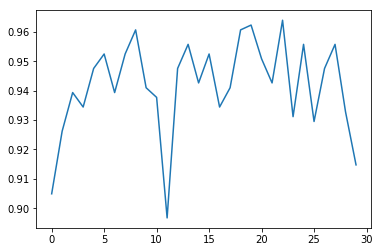

In [71]:
plt.plot(hist)